## A little introduction.

One of my tasks at a previous job was to supply medical equipment to the hospitals in Russia. <br/>
At this moment there is a goverment regulation of the possible options for the purchase of medical equipment in hospitals. <br/>
The procedure calls "Tender" and Tenders placed on the public site. Everyone can apply for participation and win Tender. The one who offers the lowest price will be a winner.
In an ideal world, technical specifications for the necessary equipment should not imply a specific brand of manufacturer. (as an example - analogy: costumer can’t write - we want to buy "The lastest model of iMac." It will be correct to write: we need a PC with 8 cores, with a frequency of 2.2 megahertz, 8 GB RAM. A hard disk of at least 250 GB, etc.)<br/>
But in fact, many manufacturers have their own set of unique technical characteristics that uniquely define the company. And the technical task of the tender is designed so that only one company-brand corresponds to the description.<br/>
That was in my case - medical equipment.<br/>
I'am, as a supplier, very interested in quickly identifying a specific manufacturer in order to be the first to negotiate and get the minimum price. This is a guarantee of victory in the tender.<br/>
I have compiled a parser that pulls data from the site (zakupki.gov.ru), where the results of public tenders are published. Here, by the way, several options are possible. Parse from the page, or from ftp, or take a json from the guys who share the already marked up information (Проект КГИ “Госзатраты” (https://clearspending.ru)<br/>
I took the data for 2017 year. And in the Sverdlovsk region (geographical entity in Russia).
Results are a contract with a large number of details. Since, initially, it was not planned to use ML. I've scrapepd data just for only a one-time analytics. The following indicators were unloaded:
- customer.inn - unique identifier of the customer (hospital)
- regNum - contract unique identifier
- signDate - date of contract signing
- Name - the actual specification of the proposed to the delivery of equipment.
- product_price - price of equipment
- Quantity - the amount of equipment
- inn - the unique identifier of the winner
- Manufacturer - target. The names of Manufacturers


link to the data - https://drive.google.com/open?id=1S9X_B9Vayev_mu9co8mVR0acdeU5uBTw <br/>
This task is similar to Medium competition. <br/>
Instead of the content of articles - those task. <br/>
And various features for a possible improvement in the speed. <br/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('Urology_department.csv', delimiter=';', converters={'customer.inn':str,\
                                                                                                           'signDate':pd.to_datetime})
data.head()

,customer.inn,regNum,signDate,name,Manufacturer,product_price,quantity,inn
0,4501008880,2450100888016000201,2016-06-20,"Экстрактор «Захват», корзинка Дормиа5-х бранше...",Coloplast,31480.0,2,8602217485
1,4501008880,2450100888016000201,2016-06-20,"Экстрактор «Захват», корзинка Дормиа 4-х бранш...",Coloplast,31480.0,1,8602217485
2,4501008880,2450100888017000114,2017-06-06,Дренажный/сменный катетер типа Pigtail с закры...,Bioteq,4080.0,25,7452128129
3,4501008880,2450100888017000114,2017-06-06,"Мочеточниковый cтент c закрытым концом, без фи...",Bioteq,3887.0,50,7452128129
4,4501008880,2450100888017000114,2017-06-06,Мочеточниковый стент длительного стояния с за...,Bioteq,7373.0,25,7452128129


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 8 columns):
customer.inn     2692 non-null object
regNum           2692 non-null object
signDate         2692 non-null datetime64[ns]
name             2692 non-null object
Manufacturer     2692 non-null object
product_price    2632 non-null float64
quantity         2692 non-null int64
inn              2692 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 168.3+ KB


In [4]:
data.isnull().any()

customer.inn     False
regNum           False
signDate         False
name             False
Manufacturer     False
product_price     True
quantity         False
inn              False
dtype: bool

In [5]:
data = data.dropna()

Ok. There are no NAN values. all types are correct

In [6]:
data.shape

(2632, 8)

Let's take a look on our target variable

In [7]:
data.Manufacturer.value_counts()

0                                     945
Coloplast                             585
TELEFLEX                              368
COLOPLAST                             234
МИТ                                   128
APEXMED                                51
Braun                                  39
BOSTON                                 31
Россия                                 26
ROCAMED                                22
Covidien                               21
Китай                                  19
COOK                                   18
Urovision                              13
Boston                                 13
Karl Storz                             12
PlastiMed                              11
Promedon                                9
G.T.A. S.r.l.                           7
Bioteq                                  7
Unomedical                              6
ЛабориМедикалТехнолоджис Инк            6
Balton                                  5
США                               

There are many "0" values. It's mean that we don't know manufacturer. We'll drop this rows. And one manufacturer duplicated ("Coloplast" and "COLOPLAST"). We'll lowecase all target manufacturers names. And we don't interesting in counts less then 10. (They are so rare that they can be neglected.)

By the way - the most time i spent to prepare data. Because published contracts don't have information about manufacturers. Either it is, but it very unstructured. I've create target variable myself.

In [8]:
data.Manufacturer = data.Manufacturer.str.lower()
cnt = data.Manufacturer.value_counts()
data = data.loc[(data.Manufacturer != '0') & (data.Manufacturer.isin(cnt.index[cnt >= 10]).values)]

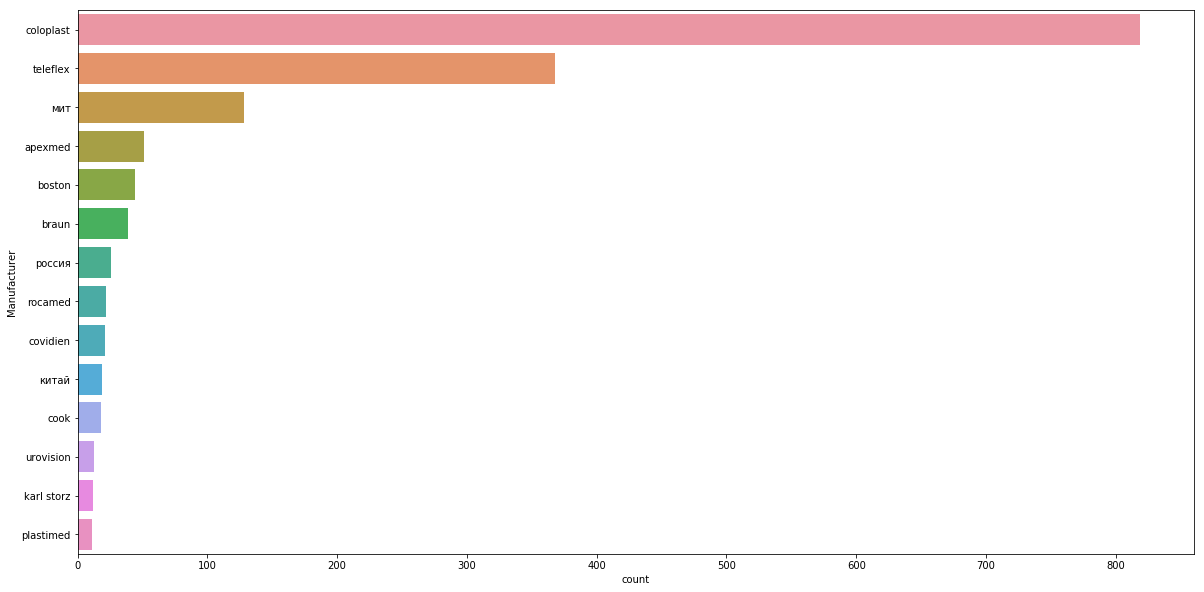

In [9]:
plt.figure(figsize=(20,10))
sns.countplot(y="Manufacturer", data=data, order = data.Manufacturer.value_counts().index)

My task is to create a classifier for 14 classes

Let's take a look on other categorial variables. Costumer.inn and inn of winner

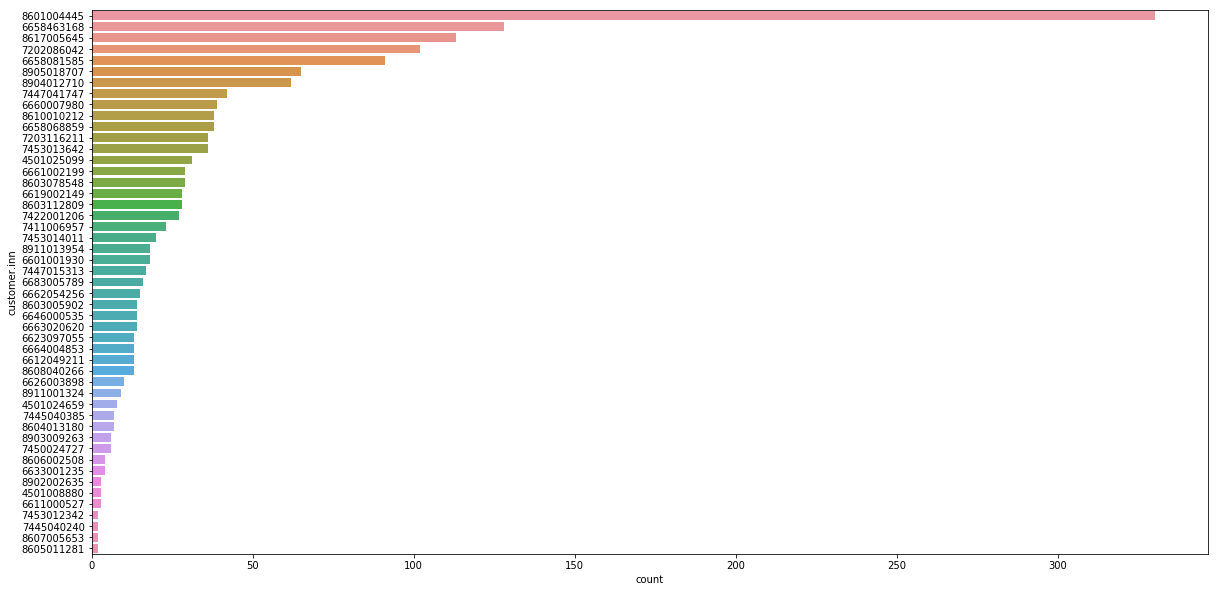

In [10]:
plt.figure(figsize=(20,10))
sns.countplot(y="customer.inn", data=data, order = data["customer.inn"].value_counts().index)

And the winner.inn

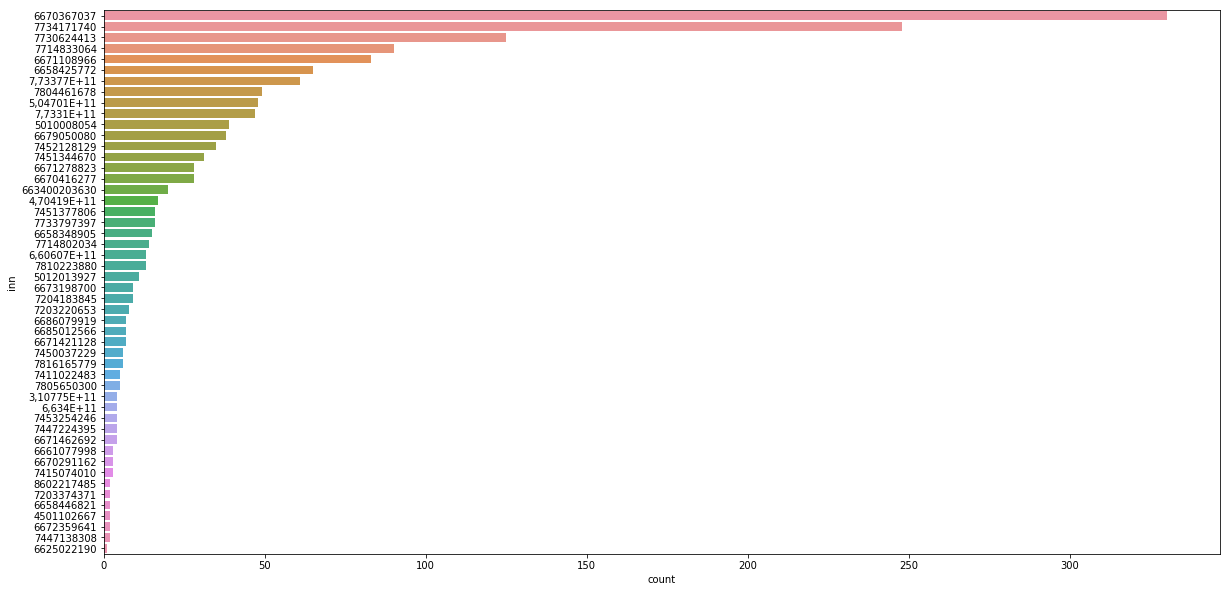

In [11]:
plt.figure(figsize=(20,10))
sns.countplot(y="inn", data=data, order = data["inn"].value_counts().index)

We have leaders in terms of purchases and supplies. <br/>
Let's take a look what brands of Manufacturers are they sell into hospitals

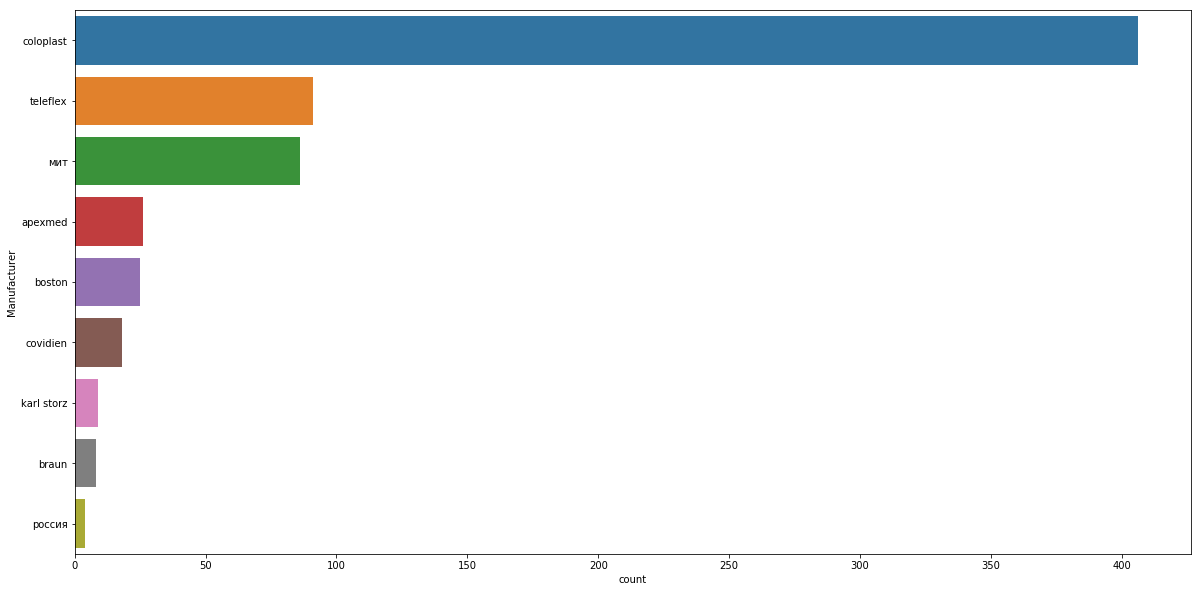

In [12]:
cnt_l_c = data["customer.inn"].value_counts()
df_leaders_costumers = data.loc[data["customer.inn"].isin(cnt_l_c.index[cnt_l_c >= 100]).values]
plt.figure(figsize=(20,10))
sns.countplot(y="Manufacturer", data=df_leaders_costumers, order = df_leaders_costumers.Manufacturer.value_counts().index)

I don't think this feature will be useful..

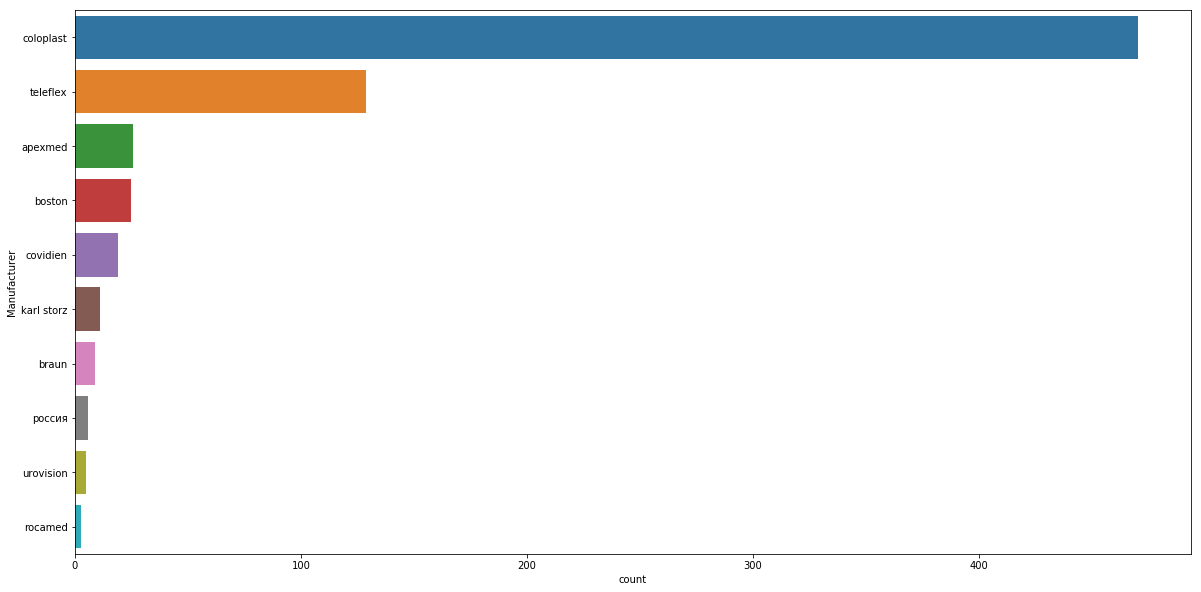

In [13]:
cnt_l_s = data["inn"].value_counts()
df_leaders_suppliers = data.loc[data["inn"].isin(cnt_l_s.index[cnt_l_s >= 100]).values]
plt.figure(figsize=(20,10))
sns.countplot(y="Manufacturer", data=df_leaders_suppliers, order = df_leaders_suppliers.Manufacturer.value_counts().index)

We can see that some target manufacturers are not presented. But distribution is look alike to our start. 

And let's look to the date of contract

In [14]:
data['day'] = data['signDate'].apply(pd.datetime.weekday)
data['month'] = data['signDate'].apply(lambda x: x.month)

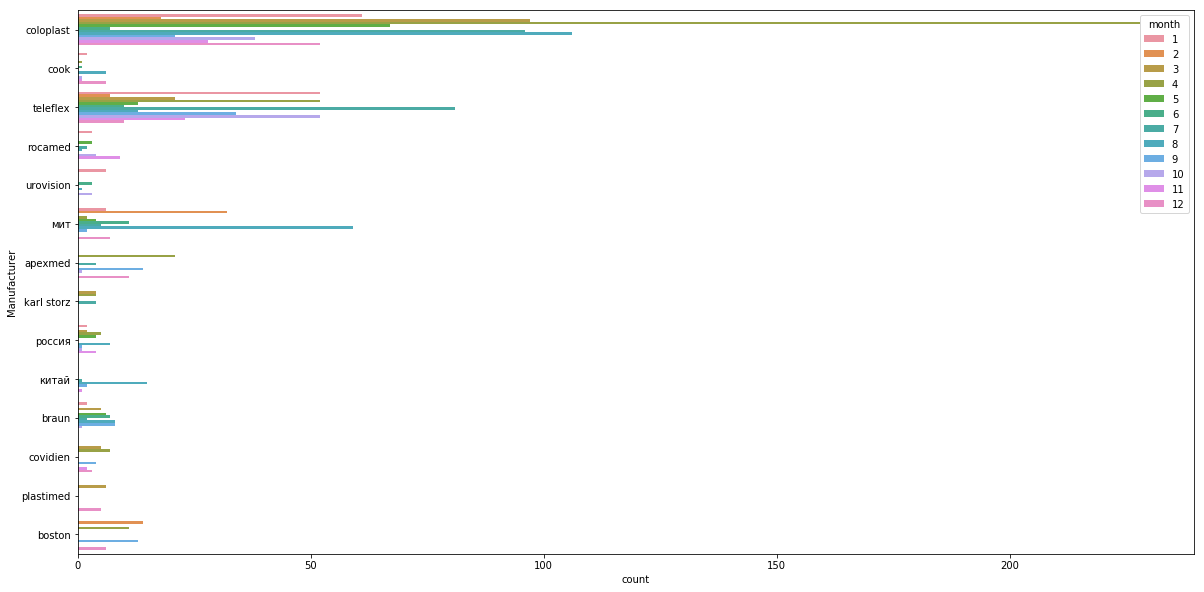

In [15]:
plt.figure(figsize=(20,10))
sns.countplot(y="Manufacturer", data=data, hue='month')

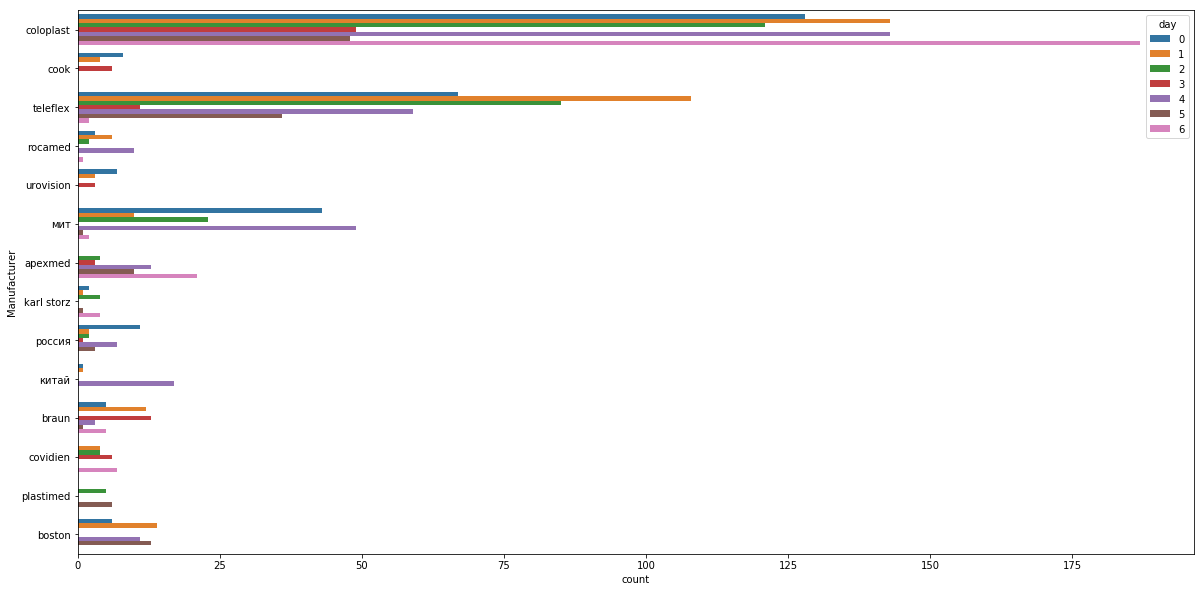

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(y="Manufacturer", data=data, hue='day')

At the first time let's build a model with only Description of Manufacturer as feature

In [17]:
train_part, test_part = train_test_split(data[['name','Manufacturer']], test_size=0.2, random_state=21, stratify=data["Manufacturer"])

In [18]:
pipeline_tfidf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                              ('lr', LogisticRegression())])

pipeline_tfidf_lr.fit(train_part['name'], train_part["Manufacturer"])

predicted = pipeline_tfidf_lr.predict(test_part["name"])

Confusion matrix

In [19]:
test_classes_counts = test_part["Manufacturer"].value_counts()
test_classes_names = np.array(test_classes_counts.index)
total_classes = len(test_classes_counts)


cm = confusion_matrix(y_true=test_part["Manufacturer"], y_pred=predicted, labels=test_classes_names)
for true_class_id in range(total_classes):
    true_class_name = test_classes_names[true_class_id]
    true_class_count = test_classes_counts[true_class_name]
    
    print('For Manufacturer "{0}" ({1} test examples) were predicted:'.format(true_class_name, true_class_count))
    for pred_class_id in range(total_classes):
        percent = int(cm[true_class_id, pred_class_id].item()) / int(true_class_count.item()) * 100
        if percent >= 5:
            pred_class_name = test_classes_names[pred_class_id]
            print('\t"{0}" в {1:.2f} % ({2} раз)'.format(pred_class_name, percent, cm[true_class_id, pred_class_id]))

For Manufacturer "coloplast" (164 test examples) were predicted:
	"coloplast" в 95.73 % (157 раз)
For Manufacturer "teleflex" (74 test examples) were predicted:
	"coloplast" в 9.46 % (7 раз)
	"teleflex" в 90.54 % (67 раз)
For Manufacturer "мит" (26 test examples) were predicted:
	"coloplast" в 15.38 % (4 раз)
	"мит" в 80.77 % (21 раз)
For Manufacturer "apexmed" (10 test examples) were predicted:
	"coloplast" в 10.00 % (1 раз)
	"teleflex" в 10.00 % (1 раз)
	"apexmed" в 80.00 % (8 раз)
For Manufacturer "boston" (9 test examples) were predicted:
	"coloplast" в 22.22 % (2 раз)
	"boston" в 77.78 % (7 раз)
For Manufacturer "braun" (8 test examples) were predicted:
	"coloplast" в 25.00 % (2 раз)
	"teleflex" в 12.50 % (1 раз)
	"braun" в 62.50 % (5 раз)
For Manufacturer "россия" (5 test examples) were predicted:
	"coloplast" в 60.00 % (3 раз)
	"россия" в 40.00 % (2 раз)
For Manufacturer "covidien" (4 test examples) were predicted:
	"coloplast" в 50.00 % (2 раз)
	"covidien" в 50.00 % (2 раз)
For

In [20]:
time_split = TimeSeriesSplit(n_splits=5)

In [21]:
from sklearn.model_selection import GridSearchCV

parameters_lr = {'tfidf__ngram_range': [(1, 1), (1, 2)],
                 'tfidf__use_idf': (True, False),
                 'tfidf__max_features': [50000, 100000],
                 'lr__C': np.logspace(-2, 2, 10),
                 }

gs_lr = GridSearchCV(pipeline_tfidf_lr, parameters_lr, scoring="accuracy", n_jobs=4, cv=time_split, verbose=10,
                     return_train_score=True)
gs_lr = gs_lr.fit(data["name"], data["Manufacturer"])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   23.9s
[Parallel(

In [23]:
gs_lr.best_params_

{'lr__C': 12.915496650148826,
 'tfidf__max_features': 50000,
 'tfidf__ngram_range': (1, 2),
 'tfidf__use_idf': True}

Let's try to prepare text data with removing special characters. <br/>
And stemm it

In [24]:
import nltk
from nltk.stem import  SnowballStemmer
import re
stemmer = SnowballStemmer('russian')

In [25]:
def remove_spec_char(string):
    return re.sub('[?|#|$|.|!|0-9|²|)|(|,|–|+|”|—|’|/]', '', string)

def steming(string):
    singles = [stemmer.stem(word) for word in string.split()]
    return " ".join(singles)

In [26]:
data.name = data.name.apply(remove_spec_char)
data.name = data.name.apply(steming)

Train our model on prepared data

In [27]:
pipeline_tfidf_lr_prep = Pipeline(
    [('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=True, max_features=50000)),
     ('lr', LogisticRegression(C=12.915496650148826)),
     ])

In [28]:
train_part, test_part = train_test_split(data[['name','Manufacturer']], test_size=0.2, random_state=21, stratify=data["Manufacturer"])
pipeline_tfidf_lr_prep.fit(train_part["name"], train_part["Manufacturer"])
predicted = pipeline_tfidf_lr_prep.predict(test_part["name"])

In [29]:
test_classes_counts = test_part["Manufacturer"].value_counts()
test_classes_names = np.array(test_classes_counts.index)
total_classes = len(test_classes_counts)

cm = confusion_matrix(y_true=test_part["Manufacturer"], y_pred=predicted, labels=test_classes_names)
for true_class_id in range(total_classes):
    true_class_name = test_classes_names[true_class_id]
    true_class_count = test_classes_counts[true_class_name]
    
    print('For Manufacturer "{0}" ({1} test examples) were predicted:'.format(true_class_name, true_class_count))
    for pred_class_id in range(total_classes):
        percent = int(cm[true_class_id, pred_class_id].item()) / int(true_class_count.item()) * 100
        if percent >= 5:
            pred_class_name = test_classes_names[pred_class_id]
            print('\t"{0}" в {1:.2f} % ({2} раз)'.format(pred_class_name, percent, cm[true_class_id, pred_class_id]))

For Manufacturer "coloplast" (164 test examples) were predicted:
	"coloplast" в 96.34 % (158 раз)
For Manufacturer "teleflex" (74 test examples) were predicted:
	"teleflex" в 98.65 % (73 раз)
For Manufacturer "мит" (26 test examples) were predicted:
	"мит" в 92.31 % (24 раз)
For Manufacturer "apexmed" (10 test examples) were predicted:
	"coloplast" в 10.00 % (1 раз)
	"apexmed" в 90.00 % (9 раз)
For Manufacturer "boston" (9 test examples) were predicted:
	"boston" в 100.00 % (9 раз)
For Manufacturer "braun" (8 test examples) were predicted:
	"braun" в 100.00 % (8 раз)
For Manufacturer "россия" (5 test examples) were predicted:
	"россия" в 100.00 % (5 раз)
For Manufacturer "covidien" (4 test examples) were predicted:
	"covidien" в 100.00 % (4 раз)
For Manufacturer "китай" (4 test examples) were predicted:
	"teleflex" в 25.00 % (1 раз)
	"китай" в 75.00 % (3 раз)
For Manufacturer "rocamed" (4 test examples) were predicted:
	"coloplast" в 25.00 % (1 раз)
	"rocamed" в 75.00 % (3 раз)
For Man

Now let's add other features, and take a look on results

In [30]:
scaler = StandardScaler()
tfidf = TfidfVectorizer(ngram_range=(1, 2), use_idf=True, max_features=50000)
lr = LogisticRegression(C=12.915496650148826)

In [31]:
data = pd.get_dummies(data, columns=['customer.inn', 'inn', 'day', 'month'])
data.drop(columns=['regNum','signDate'], inplace=True)

In [32]:
tmp = StandardScaler().fit_transform(data[['product_price','quantity']])
text = tfidf.fit_transform(data.name)
features = data.iloc[:,4:].values

C:\Users\m.korshikov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\m.korshikov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [33]:
X = csr_matrix(hstack([text, tmp, features]))
y = data.Manufacturer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [34]:
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)

In [35]:
test_classes_counts = test_part["Manufacturer"].value_counts()
test_classes_names = np.array(test_classes_counts.index)
total_classes = len(test_classes_counts)

In [36]:
cm = confusion_matrix(y_true=test_part["Manufacturer"], y_pred=predicted, labels=test_classes_names)

In [37]:
for true_class_id in range(total_classes):
    true_class_name = test_classes_names[true_class_id]
    true_class_count = test_classes_counts[true_class_name]
    
    print('For Manufacturer "{0}" ({1} test examples) were predicted:'.format(true_class_name, true_class_count))
    for pred_class_id in range(total_classes):
        percent = int(cm[true_class_id, pred_class_id].item()) / int(true_class_count.item()) * 100
        if percent >= 5:
            pred_class_name = test_classes_names[pred_class_id]
            print('\t"{0}" в {1:.2f} % ({2} раз)'.format(pred_class_name, percent, cm[true_class_id, pred_class_id]))

For Manufacturer "coloplast" (164 test examples) were predicted:
	"coloplast" в 98.17 % (161 раз)
For Manufacturer "teleflex" (74 test examples) were predicted:
	"teleflex" в 100.00 % (74 раз)
For Manufacturer "мит" (26 test examples) were predicted:
	"мит" в 100.00 % (26 раз)
For Manufacturer "apexmed" (10 test examples) were predicted:
	"coloplast" в 10.00 % (1 раз)
	"apexmed" в 90.00 % (9 раз)
For Manufacturer "boston" (9 test examples) were predicted:
	"boston" в 100.00 % (9 раз)
For Manufacturer "braun" (8 test examples) were predicted:
	"coloplast" в 12.50 % (1 раз)
	"braun" в 87.50 % (7 раз)
For Manufacturer "россия" (5 test examples) were predicted:
	"россия" в 100.00 % (5 раз)
For Manufacturer "covidien" (4 test examples) were predicted:
	"covidien" в 100.00 % (4 раз)
For Manufacturer "китай" (4 test examples) were predicted:
	"teleflex" в 25.00 % (1 раз)
	"китай" в 75.00 % (3 раз)
For Manufacturer "rocamed" (4 test examples) were predicted:
	"teleflex" в 75.00 % (3 раз)
	"roc

So, we increase our score with new features

### The main reason for completing this task is:
- Reduced time to process incoming tenders <br/>
- Receiving profitable conditions from manufacturers (remember, who is the first to request - the one has the maximum discount)<br/>
- And this is the key to winning the tender.<br/>
- Reduction or switching to other tasks of a qualified staff of the organization.<br/>
- Cost reduction and profit growth organization.

### What can be done next:
- The main direction I would choose - enrichment with new data. Grabing new contracts, marking on unknown manufacturers.
- The use of other models (random forest, svm and others ...)